# Linear Regression

Работа выполнена студентом группы 23КНТ2 ИМИКН ВШЭ НН ***Власовым Артёмом Дмитриевичем***

Заранее предупреждаем, что оценка, посчитанная в конце ноутбука не является итоговой, ноутбук будет запущен заново и проверка руками тоже будет. Эта оценка будет предварительной.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
grade_lst = []

### Dataset

ACME Insurance Inc. предлагает доступную медицинскую страховку тысячам клиентов по всей территории Соединенных Штатов. Перед вами стоит задача создать автоматизированную систему для оценки ежегодных расходов на медицинское обслуживание новых клиентов с использованием такой информации, как их возраст, пол, индекс массы тела, количество детей, привычки к курению и регион проживания.

[dataset](https://www.kaggle.com/datasets/harshsingh2209/medical-insurance-payout/data)

In [3]:
df = pd.read_csv('expenses.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


## EDA

Проверьте есть ли пропущенные значения в столбцах

In [5]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

**Пояснение**: пропущенных значенений в столбцах нет

Проверьте есть ли повторяющиеся строки

In [6]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1333    False
1334    False
1335    False
1336    False
1337    False
Length: 1338, dtype: bool

**Пояснение**: повторяющихся строк нет

### Кодировка категориальных признаков

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


Закодируйте категориальные признаки с помощью OneHotEncoder (используя drop='first')

In [8]:
from sklearn.preprocessing import OneHotEncoder

In [9]:
encoder = OneHotEncoder(drop='first')
categorical_cols = ['region', 'sex', 'smoker']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

**Задание 1:** укажите в переменные mean_region, mean_sex, df_shape среднее значение по новой закодированной колонке region, среднее по колонке sex и размер нового датасета соответственно

In [10]:
df.head()

,age,bmi,children,charges,region_northwest,region_southeast,region_southwest,sex_male,smoker_yes
0,19,27.900,0,16884.92400,False,False,True,False,True
1,18,33.770,1,1725.55230,False,True,False,True,False
2,28,33.000,3,4449.46200,False,True,False,True,False
3,33,22.705,0,21984.47061,True,False,False,True,False
4,32,28.880,0,3866.85520,True,False,False,True,False


In [11]:
mean_region = df[["region_northwest", "region_southeast", "region_southwest"]].mean().mean()
mean_sex = df['sex_male'].mean()
df_shape = df.shape[1]

grade_lst.append(mean_region)
grade_lst.append(mean_sex)
grade_lst.append(df_shape)

In [12]:
print(mean_region)
print(mean_sex)
print(df_shape)

0.25261584454409564
0.5052316890881914
9


Постройте матрицу корреляций

In [13]:
import seaborn as sns

<Axes: >

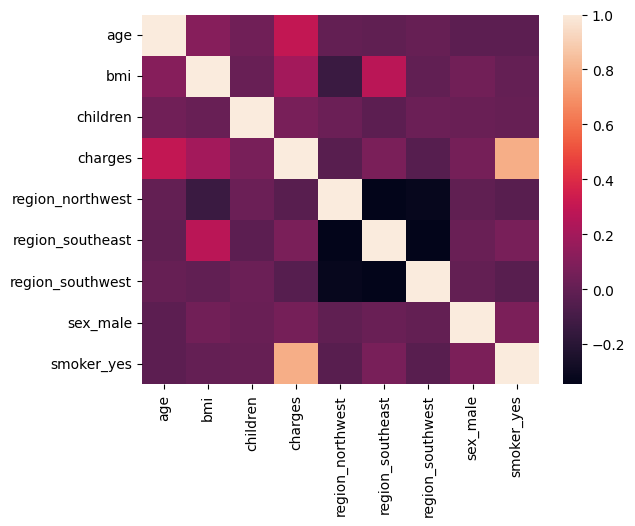

In [14]:
corr = df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

**Задание 2**: Укажите в ячейке ниже в переменную most_correlated признак, который больше всех коррелирует с целевой переменной (charges)

In [15]:
most_correlated = corr['charges'].drop('charges').abs().idxmax()
print(most_correlated)
grade_lst.append(most_correlated)

smoker_yes


Линейная регрессия на входе должна иметь параметры одного масштаба, поэтому давайте отнормируем вещественные признаки с помощью StandardScaler

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols.remove('charges')
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

Разделите данные на train и test часть (test_size=0.25, random_state=42)

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X = df.drop(columns=['charges'])
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Модель

In [20]:
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [21]:
model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [22]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

In [23]:
print(f"Среднеквадратичная ошибку на тренировочной выборке: {train_mse}")
print(f"Среднеквадратичная ошибку на тестовой выборке: {test_mse}")

Среднеквадратичная ошибку на тренировочной выборке: 37004502.18409475
Среднеквадратичная ошибку на тестовой выборке: 35117755.73613634


Изучите документацию модуля LinearRegression и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [24]:
coefficients = pd.Series(model.coef_, index=X.columns)
coefficients

age                  3646.338386
bmi                  2071.420085
children              513.953768
region_northwest     -355.148621
region_southeast     -781.368389
region_southwest     -860.266712
sex_male               45.622427
smoker_yes          23630.398990
dtype: float64

**Задание 3:** в переменную most_importnace_features укажите три признака, имеющих больший feature_importance

In [25]:
coefficients.abs().nlargest(3).index.tolist()

['smoker_yes', 'age', 'bmi']

In [26]:
most_importance_features = coefficients.abs().nlargest(3).index.tolist()

grade_lst.append(most_importance_features.copy())

#### Регуляризация

Один из важнейших пунктов при использовании линейных моделей, так как они являются достаточно слабыми, они всеми силами стараются переобучиться, поэтому мы используем регуляризацию, которая контроллирует норму весов, не давая коэфициентам становиться очень большими.

Cмысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:


$||y - X\hat{w}|| + \alpha \sum\limits_{i = 1}^n |w_i|$


Такая модель называется **Lasso-регрессией**.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:


$||y - X\hat{w}|| + \alpha \sum\limits_{i = 1}^n ||w_i||^2$

Такая модель называется **Ridge-регрессией**.

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули Lasso и Ridge из sklearn.

In [27]:
lasso = Lasso(alpha=10)
ridge = Ridge(alpha=10)

lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)

lasso_mse = mean_squared_error(y_test, lasso.predict(X_test))
ridge_mse = mean_squared_error(y_test, ridge.predict(X_test))

In [28]:
print(f"lasso_mse: {lasso_mse};\n ridge_mse: {ridge_mse}")

lasso_mse: 35152681.12845146;
 ridge_mse: 35790193.18166306


**Задание 4:** Укажите в переменную best_model какая модель дала лучшее качество на тесте (Lasso или Ridge)

In [29]:
best_model = 'lasso' if lasso_mse < ridge_mse else 'ridge'

grade_lst.append(best_model)

Постройте график нормы вектора коэфициентов для коэфициентов регуляризации (0.1, 1, 10, 100, 1000, 10000).

Как мы знаем Lasso зануляет коэфициенты при достаточно больших коэфициентах регуляризации. Для каждого коэфициента зафиксируйте количество признаков, у которых ненулевой feature_importance

In [30]:
alphas = [0.1, 1, 10, 100, 1000, 10000]
lasso_coefs = []
nonzero_counts = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    lasso_coefs.append(np.linalg.norm(lasso.coef_))
    nonzero_counts.append(np.sum(lasso.coef_ != 0))

In [31]:
# Количество ненулевых коэффициентов
nonzero_counts

[np.int64(8), np.int64(8), np.int64(8), np.int64(4), np.int64(3), np.int64(0)]

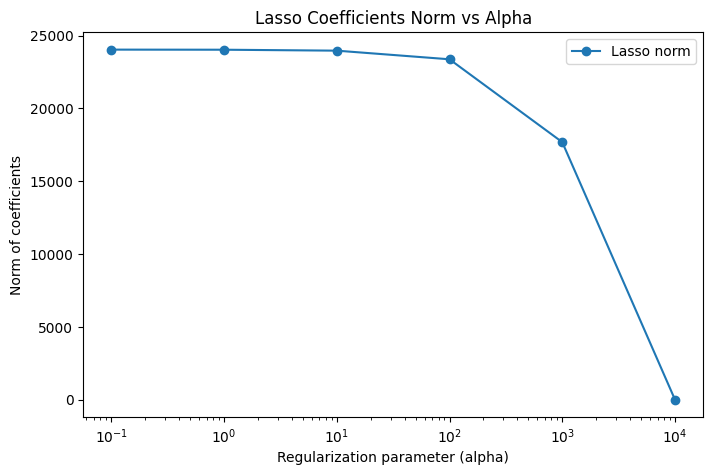

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(alphas, lasso_coefs, marker='o', label='Lasso norm')
plt.xscale('log')
plt.xlabel('Regularization parameter (alpha)')
plt.ylabel('Norm of coefficients')
plt.title('Lasso Coefficients Norm vs Alpha')
plt.legend()
plt.show()


**Задание 5:** Укажите для какого коэфициенте регуляризации у Lasso остается всего 3 коэфициента с ненулевым feature_importance

In [33]:
three_non_zero_features_alpha = alphas[next(i for i, count in enumerate(nonzero_counts) if count == 3)]
print(three_non_zero_features_alpha)
grade_lst.append(three_non_zero_features_alpha)

1000


Давайте вспомним про кросс-валидацию, это метод оценивания качества модели на тренировочной выборке, работает по следующему алгоритму:

1. Делим выборку на некоторое количество фолдов (обычно 5)

2. Обучаем модель на всех кроме одного фолда, и на оставшемся фолде оцениваем качество

3. Повторяем пункт 2 для всех фолдов

4. В конце считаем среднее качество по всем фолдам

Итого обучаем 5 раз модель (в этом минус кросс-валидации, если данных много или модель тяжелая, то она может затянуться)


Используя LassoCV с количеством фолдов 5 посчитайте для каждого alpha из предыдущего задания MSE на кросс-валидации

In [34]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

In [35]:
lasso_cv_mse = {}
for alpha in alphas:
    lasso_cv = LassoCV(alphas=[alpha], cv=5)
    lasso_cv.fit(X_train, y_train)
    lasso_cv_mse[alpha] = -np.mean(cross_val_score(lasso_cv, X_train, y_train, scoring='neg_mean_squared_error', cv=5))

**Задание 6:** Запишите в переменную best_lasso_alpha коэфициент alpha, при котором достигается наименьший MSE на кросс-валидации

In [36]:
lasso_cv_mse

{0.1: np.float64(37718653.17977096),
 1: np.float64(37716157.504426196),
 10: np.float64(37697176.02576449),
 100: np.float64(37569740.04952149),
 1000: np.float64(45856852.80661169),
 10000: np.float64(145206937.89072728)}

In [37]:
min(lasso_cv_mse, key=lasso_cv_mse.get)

100

In [38]:
best_lasso_alpha = min(lasso_cv_mse, key=lasso_cv_mse.get)

grade_lst.append(best_lasso_alpha)

Обучите Lasso с лучшим alpha и посчитайте MSE на тесте

In [39]:
best_lasso = Lasso(alpha=best_lasso_alpha)
best_lasso.fit(X_train, y_train)
best_lasso_mse = mean_squared_error(y_test, best_lasso.predict(X_test))

In [40]:
print(best_lasso_mse)

35617699.57838276


### Полиномиальные признаки

Линейная регрессия является слабой как раз по причине того, что она собирает лишь линейную комбинацию имеющихся признаков. Поэтому для улучшения можно добавить полиномиальных признаков руками (степени признаков, или произведения признаков).

In [41]:
from sklearn.preprocessing import PolynomialFeatures
import time

Посчитайте для degree = [2, 3, 4, 5, 6, 7, 8, 9, 10] количество признаков и время за которое обучается модель

In [42]:
degrees = [2, 3, 4, 5, 6, 7, 8, 9, 10]
feature_counts = []
train_times = []
test_mses = []

for degree in degrees:
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)
    feature_counts.append(X_poly.shape[1])

    X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.25, random_state=42)

    start_time = time.time()
    lr_poly = LinearRegression()
    lr_poly.fit(X_train_poly, y_train_poly)
    end_time = time.time()

    train_times.append(end_time - start_time)
    test_mses.append(mean_squared_error(y_test_poly, lr_poly.predict(X_test_poly)))


In [43]:
# Выводим количество признаков и времени обучения
feature_counts, train_times

([45, 165, 495, 1287, 3003, 6435, 12870, 24310, 43758],
 [0.005448102951049805,
  0.015911579132080078,
  0.056902408599853516,
  0.35405540466308594,
  0.6359329223632812,
  1.0151941776275635,
  2.0642776489257812,
  3.884169101715088,
  6.834555387496948])

**Задание 7:** Укажите в переменную degree_8_n_features сколько признаков в датасете при 8 степени полинома

In [44]:
degree_8_n_features = feature_counts[degrees.index(8)]
print(degree_8_n_features)
grade_lst.append(degree_8_n_features)

12870


**Задание 8:** Укажите в переменную best_degree степень, при которой MSE на тесте лучшее

In [45]:
best_degree = degrees[np.argmin(test_mses)]
print(best_degree)
grade_lst.append(best_degree)

2


Постройте следующие графики в зависимости от степени полинома:

1. Количество признаков

2. Время обучения

3. Качество на тесте

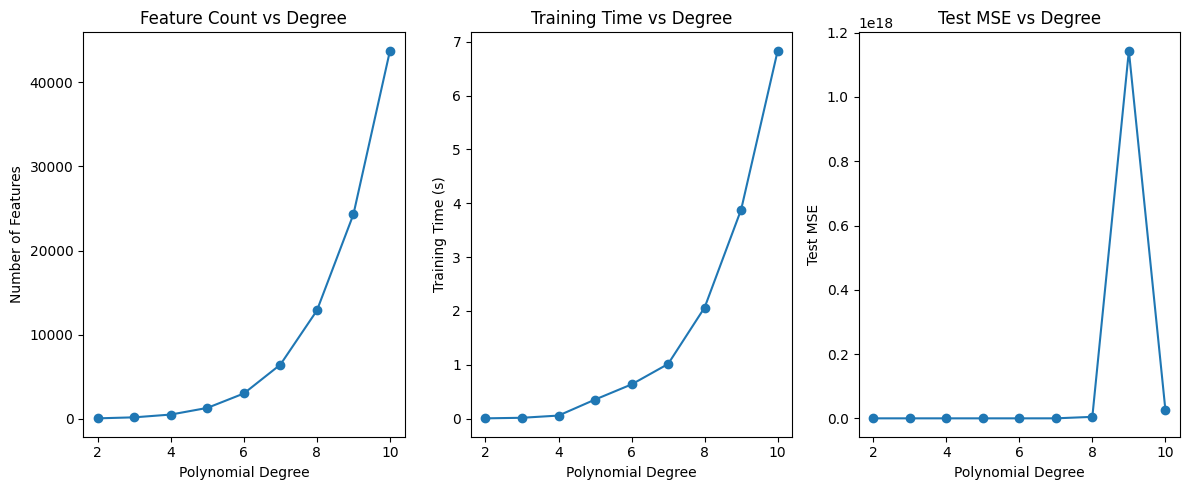

In [46]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(degrees, feature_counts, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Number of Features')
plt.title('Feature Count vs Degree')

plt.subplot(1, 3, 2)
plt.plot(degrees, train_times, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Training Time (s)')
plt.title('Training Time vs Degree')

plt.subplot(1, 3, 3)
plt.plot(degrees, test_mses, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Test MSE')
plt.title('Test MSE vs Degree')

plt.tight_layout()
plt.show()

## Оценка

In [47]:
def grade(grade_lst, epsilon=10e-4):
    if len(grade_lst) < 10:
        grade_lst += [-float('inf')] * (10 - len(grade_lst))

    res = 0
    if abs(grade_lst[0] - 0.25261584454409564) < epsilon:
        res += 1
    if abs(grade_lst[1] - 0.5052316890881914) < epsilon:
        res += 1
    if grade_lst[2] == 9:
        res += 1
    if grade_lst[3] == 'smoker_yes':
        res += 1

    res += int('smoker_yes' in grade_lst[4]) / 3
    res += int('age' in grade_lst[4]) / 3
    res += int('bmi' in grade_lst[4]) / 3

    res += int(grade_lst[5].lower() == 'lasso')

    res += int(grade_lst[6] == 1000)

    res += int(grade_lst[7] == 100)

    res += int(grade_lst[8] == 12870)

    res += int(grade_lst[9] < 4)

    return res

In [48]:
grade(grade_lst)

10.0